In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
!ls ../../data/ml-1m

movies.dat  ratings.dat  README  users.dat


In [3]:
rnames = ['user id', 'item id', 'rating', 'timestamp']
ratings = pd.read_table('../../data/ml-1m/ratings.dat', sep='::',
 header=None, names=rnames, engine='python')

In [4]:
df_train, df_test = train_test_split(ratings, test_size=0.8, random_state=42)

In [5]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [42]:
user_movies_train = (
    pd.pivot(data=df_train, index='user id', columns='item id', values='rating')
)

user_movies_train = (
    user_movies_train
     .drop(user_movies_train.index[(~user_movies_train.index.isin(df_test["user id"].unique()))], axis=0)
)
train_mask_notna = torch.tensor(user_movies_train.notna().values)

# creating tensor from user movies matrix
scaler = StandardScaler().fit(user_movies_train)
train_tensor = torch.tensor(scaler.transform(user_movies_train))
#train_tensor = torch.tensor(user_movies_train.values)

# DataLoader is used to load the dataset
# for training
train_loader = torch.utils.data.DataLoader(
    dataset = list(zip(train_tensor, train_mask_notna)),
    batch_size = 32,
    shuffle = True
)

train_tensor.shape

torch.Size([6033, 3474])

In [43]:
filled_train_tensor = torch.nan_to_num(train_tensor).float().to(device)

In [44]:
user_movies_test = (
    pd.pivot(data=df_test, index='user id', columns='item id', values='rating')
)

In [45]:
cols_train_not_in_test = user_movies_train.columns[
    ~user_movies_train.columns.isin(user_movies_test.columns)]

cols_test_not_in_train = user_movies_test.columns[
    ~user_movies_test.columns.isin(user_movies_train.columns)]

extra_cols = pd.DataFrame(
    index=user_movies_test.index,
    columns=cols_train_not_in_test
)

len(cols_train_not_in_test), len(cols_test_not_in_train)

(31, 232)

In [46]:
extra_user_movies_test = (
    pd.concat([user_movies_test, extra_cols], axis=1)
    .drop(cols_test_not_in_train, axis=1)
)
extra_user_movies_test = extra_user_movies_test.reindex(
    sorted(extra_user_movies_test.columns), axis=1
).drop(extra_user_movies_test.index[(~extra_user_movies_test.index.isin(user_movies_train.index))], axis=0)

#extra_user_movies_test = scaler.transform(extra_user_movies_test)

In [47]:
extra_user_movies_test.shape

(6033, 3474)

In [93]:
test_mask = ~torch.tensor(extra_user_movies_test.values.astype(float)).isnan()
test_ground_truth = torch.nan_to_num(torch.tensor(extra_user_movies_test.values.astype(float)))

In [49]:
n_movies = train_tensor[0].shape[0]
n_movies

3474

In [239]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_movies, 600),
            torch.nn.ReLU(),
            torch.nn.Linear(600, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 50),
        )
    
    
        self.decoder = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(50, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 600),
            torch.nn.ReLU(),
            torch.nn.Linear(600, n_movies),
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [240]:
def corrupt_X(X, ratio=0.2):
    return X * (np.random.random(size=batch_mask.shape) > ratio)

In [245]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
model = AE().to(device)
epochs=5
# Model Initialization
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 1e-4,
                             weight_decay = 0)
epoch_loss_train = []
epoch_loss_test = []
for epoch in tqdm(range(epochs)):
    train_loss = 0

    ## TRAIN MODEL ##
    # Put model in train mode
    model.train()

    # Loop through data loader data batches
    for batch, (X, batch_mask) in enumerate(train_loader):
        # Send data to target device
        X = torch.nan_to_num(X.float())
        batch_mask_flat = batch_mask.bool().flatten().to(device)
        
        ## Corrupting some of the Xs
        X_corrupted = corrupt_X(X, ratio=0).to(device)
        X = X.to(device)
        
        # 1. Forward pass
        X_pred = model(X_corrupted).flatten()[batch_mask_flat]
        # 2. Calculate  and accumulate loss
        loss = loss_function(X_pred, X.flatten()[batch_mask_flat])
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    test_error = []
    with torch.inference_mode():
        preds = model(filled_train_tensor)
        test_error = loss_function(
           preds.flatten()[test_mask.flatten()].cpu(),
           torch.tensor(scaler.transform(test_ground_truth.numpy()).flatten()[test_mask.flatten()])    
        )
        
#         test_error = mean_squared_error(
#             test_ground_truth.flatten()[test_mask.flatten()].numpy(),
#             np.clip(scaler.inverse_transform(preds.cpu().numpy()).flatten()[test_mask.flatten()], 1, 5)
#         )

    epoch_loss_train += [train_loss / len(train_loader)]
    epoch_loss_test += [test_error]

  0%|          | 0/5 [00:00<?, ?it/s]

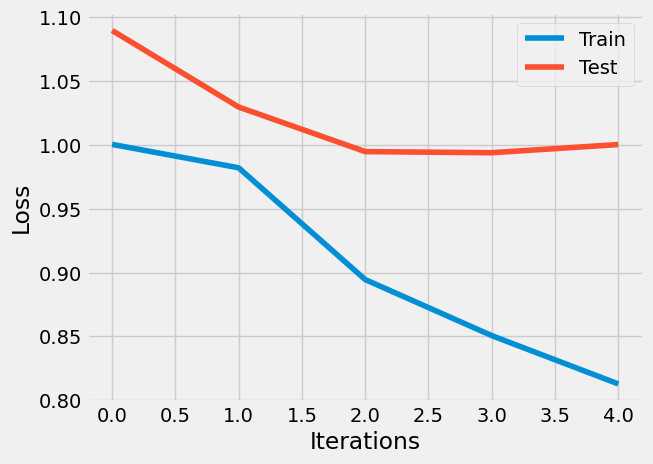

In [246]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
#plt.axvline(x=35, alpha=0.5, color='purple')
plt.legend()


In [247]:
from sklearn.metrics import mean_squared_error

In [248]:
mean_squared_error(
    test_ground_truth.flatten()[test_mask.flatten()].numpy(),
    np.clip(scaler.inverse_transform(preds.cpu().numpy()).flatten()[test_mask.flatten()], 1, 5),
    squared=True
)

0.890707387633917

In [157]:
noise = torch.tensor(
    np.array(
        [np.random.normal(loc=0,
                          scale=.2,
                          size=X.shape[1]
                          )
          for i in range(X.shape[0])
        ]
    )
).to(device)

In [ ]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
epochs=500
# Model Initialization
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 1e-4,
                             weight_decay = 1e-8)

epoch_loss_train = []
epoch_loss_test = []
for epoch in tqdm(range(epochs)):
    train_loss = 0

            ## TRAIN MODEL ##
    # Put model in train mode
    model.train()

    # Loop through data loader data batches
    for batch, (X) in enumerate(train_loader):
        
        # Send data to target device
        X = X.float().to(device)
        batch_mask = ~torch.isnan(X)
        X = torch.nan_to_num(X)
        noise = torch.tensor(np.array([np.random.normal(loc=0,
                                                        scale=.2,
                                                        size=X.shape[1])
                  for i in range(X.shape[0])])).to(device)
        X_noise = (X + noise).float().to(device) * batch_mask
        # 1. Forward pass
        X_pred = model(X_noise) * batch_mask
        # 2. Calculate  and accumulate loss
        loss = loss_function(X_pred, X)
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    test_error = []
    with torch.inference_mode():
        preds = model(filled_train_tensor)
        preds = scaler.inverse_transform(preds.cpu()).flatten()
        np.clip(preds, a_min=1, a_max=5, out=preds)
        test_error += [mean_squared_error(preds[test_mask], 
                                          test_ground_truth[test_mask], squared=False)]

    epoch_loss_train += [train_loss / len(train_loader)]
    epoch_loss_test += [test_error]

In [ ]:
print(min(epoch_loss_test))

In [ ]:
print(max(epoch_loss_test[-20:]))

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
plt.plot(epoch_loss_train, label='Train')
#plt.plot(epoch_loss_test, label='Test')
plt.legend()


In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
#plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
plt.legend()
